# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import re
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import Window
import pyspark.sql.functions as F
from pyspark.ml.feature import VectorAssembler, StandardScaler, OneHotEncoder, StringIndexer
from pyspark.ml.classification import LogisticRegression, GBTClassifier, RandomForestClassifier
from pyspark.ml.classification import LogisticRegressionModel, GBTClassificationModel, RandomForestClassificationModel
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify Capstone Project") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [16]:
path = "mini_sparkify_event_data.json"
user_log = spark.read.json(path)
user_log.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [4]:
print(user_log.count(), len(user_log.columns))

286500 18


In [4]:
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [18]:
user_log = user_log.filter((user_log.userId!="") | (user_log.sessionId!=""))

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [19]:
churn_users = user_log.filter(user_log.page=="Cancellation Confirmation").select("userId").dropDuplicates()
churn_users_list = churn_users.toPandas()['userId'].values.tolist()
user_log = user_log.withColumn('churn', user_log.userId.isin(churn_users_list))
user_log = user_log.withColumn('region', F.split(user_log.location, ', ')[1])

In [20]:
user_log.select('region').dropDuplicates().count()

58

In [7]:
set_time = F.udf(lambda x: datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
user_log = user_log.withColumn("time", F.to_timestamp(set_time(user_log.ts), 'yyyy-MM-dd HH:mm:ss'))

In [8]:
user_agg_info = user_log.groupBy('userId').agg(F.min('gender').alias('gender'),
                                                   F.min('region').alias('region'),
                                                   F.min('ts').alias('firstSession'), 
                                                   F.max('ts').alias('lastSession'),
                                                   F.count('song').alias('songsListened'),
                                                   F.count('sessionId').alias('totalSessions'),
                                                   F.min('churn').alias('churn')).sort('userId')

user_agg_info = user_agg_info.withColumn("firstSession", \
                    F.to_timestamp(set_time(user_agg_info.firstSession),'yyyy-MM-dd HH:mm:ss'))
user_agg_info = user_agg_info.withColumn("lastSession", \
                    F.to_timestamp(set_time(user_agg_info.lastSession),'yyyy-MM-dd HH:mm:ss'))
user_agg_info = user_agg_info.withColumn('totalDays', F.datediff("lastSession", "firstSession"))

In [9]:
user_agg_info.show(10)

+------+------+------+-------------------+-------------------+-------------+-------------+-----+---------+
|userId|gender|region|       firstSession|        lastSession|songsListened|totalSessions|churn|totalDays|
+------+------+------+-------------------+-------------------+-------------+-------------+-----+---------+
|    10|     M|    MS|2018-10-08 02:20:20|2018-11-19 12:49:48|          673|          795|false|       42|
|   100|     M|    TX|2018-10-02 15:04:22|2018-11-30 14:15:49|         2682|         3214|false|       59|
|100001|     F|    FL|2018-10-01 06:48:24|2018-10-02 16:36:45|          133|          187| true|        1|
|100002|     F|    CA|2018-10-08 22:57:25|2018-12-03 01:11:16|          195|          218|false|       56|
|100003|     F|    FL|2018-10-09 15:53:40|2018-10-11 16:19:41|           51|           78| true|        2|
|100004|     F|    NY|2018-10-03 02:47:15|2018-11-29 02:37:45|          942|         1245|false|       57|
|100005|     M|    LA|2018-10-01 15:1

In [9]:
user_agg_info.groupBy('churn').agg(F.count('userId')).show()

+-----+-------------+
|churn|count(userId)|
+-----+-------------+
| true|           52|
|false|          173|
+-----+-------------+



In [10]:
user_agg_info.groupBy(['churn', 'gender']).agg(F.count('userId')).show()

+-----+------+-------------+
|churn|gender|count(userId)|
+-----+------+-------------+
| true|     F|           20|
|false|     M|           89|
| true|     M|           32|
|false|     F|           84|
+-----+------+-------------+



## Visualizations
### Churn by Gender

In [11]:
df = user_agg_info.toPandas()

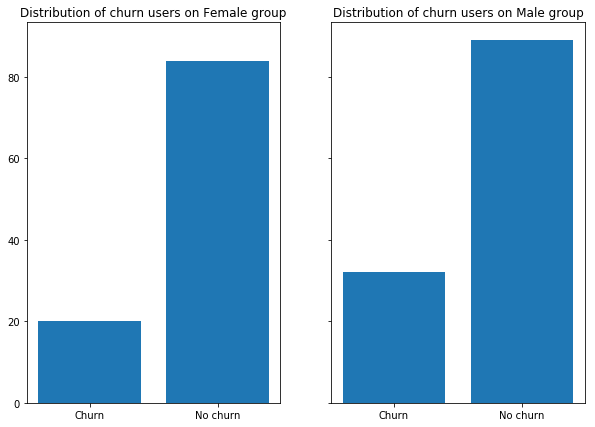

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,7), sharey=True)
ax1.bar(['No churn', 'Churn'], df[df['gender']=='F'].groupby(['churn'])['userId'].count())
ax2.bar(['No churn', 'Churn'], df[df['gender']=='M'].groupby(['churn'])['userId'].count())
ax1.set_title('Distribution of churn users on Female group')
ax2.set_title('Distribution of churn users on Male group')
plt.show()

In [13]:
df.groupby('churn')['region'].nunique()

churn
False    54
True     29
Name: region, dtype: int64

There are regions that does not have churn users. For this reason we have to be cautious including this feature into our ML model. If we have churn users in the full dataset, then it will be ok to add the feature in the model, if not, then we could overfit our model.

### Churn by Songs and Days Registered

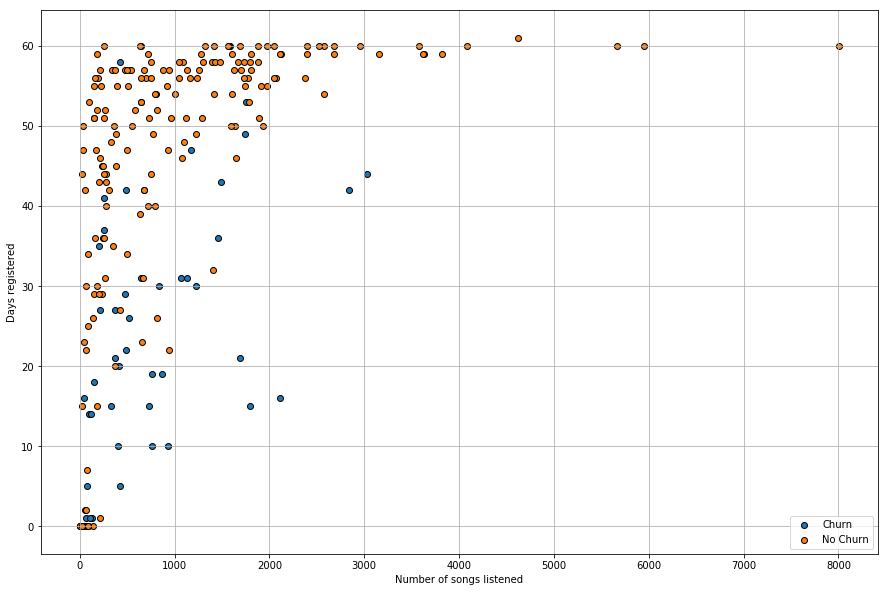

In [14]:
churn = df[df['churn']==True]
no_churn = df[df['churn']==False]

plt.figure(figsize=(15,10))
plt.scatter(churn['songsListened'], churn['totalDays'], edgecolor='black', label='Churn')
plt.scatter(no_churn['songsListened'], no_churn['totalDays'], edgecolor='black', label='No Churn')
plt.xlabel('Number of songs listened')
plt.ylabel('Days registered')
plt.grid()
plt.legend()
plt.show()

### Churn by Total Sessions

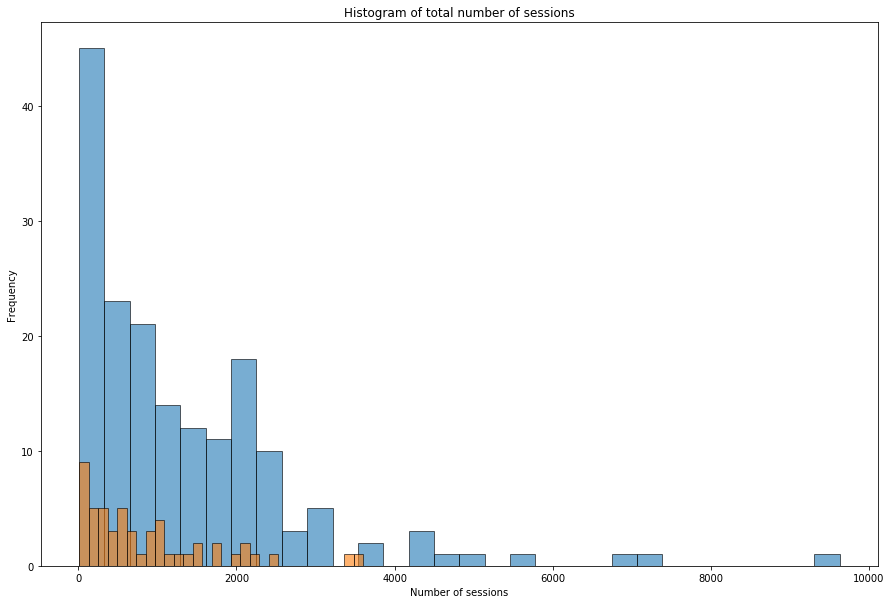

In [20]:
plt.figure(figsize=(15,10))
df.groupby('churn')['totalSessions'].plot(kind='hist', alpha=0.6, edgecolor='black', bins=30, 
                                          title='Histogram of total number of sessions')
plt.xlabel('Number of sessions')
plt.show()
df.plot

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

## Steps:

### 1. Locate the US state from the user location (already done in the previous part)

In [16]:
user_log = user_log.withColumn('region', F.split(user_log.location, ', ')[1])

### 2. Get gender, region, first/last session, number of songs listened and number of total sessions by user

In [17]:
user_agg_info = user_log.groupBy('userId').agg(F.min('gender').alias('gender'),
                                                   F.min('region').alias('region'),
                                                   F.min('ts').alias('firstSession'), 
                                                   F.max('ts').alias('lastSession'),
                                                   F.count('song').alias('songsListened'),
                                                   F.count('sessionId').alias('totalSessions')).sort('userId')

user_agg_info = user_agg_info.withColumn("firstSession", \
                    F.to_timestamp(set_time(user_agg_info.firstSession),'yyyy-MM-dd HH:mm:ss'))
user_agg_info = user_agg_info.withColumn("lastSession", \
                    F.to_timestamp(set_time(user_agg_info.lastSession),'yyyy-MM-dd HH:mm:ss'))
user_agg_info = user_agg_info.withColumn('totalDays', F.datediff("lastSession", "firstSession"))
user_agg_info = user_agg_info.drop('firstSession').drop('lastSession')

### 3. Get the current suscription plan of each user

In [18]:
user_level = user_log.groupby("userId", "level").agg(F.max(user_log.time).alias("lastSession")).sort("userId")
user_last_level = user_level.groupBy('userId').agg(F.max(user_level.lastSession).alias('lastSession'))
user_last_level = user_last_level.join(user_level, 
                  [user_level.userId == user_last_level.userId,
                  user_last_level.lastSession == user_level.lastSession]).select(
                  user_level.userId, "level").sort("userId")

### 4. Compute the number of clicks to each page by user

In [19]:
user_page_counts_long = user_log.groupBy(['userId', 'page']).agg(F.count('page').alias('clicks'))
user_page_counts_wide = user_page_counts_long.groupBy('userId').pivot('page').agg(F.first('clicks')).sort('userId')
# Dropping Cancel and Cancelation Page as it is the page of churn
user_page_counts_wide = user_page_counts_wide.drop('Cancel') 
user_page_counts_wide = user_page_counts_wide.drop('Cancellation Confirmation') 
# Replacing nulls by 0 as they represent absence of clicks in that page
user_page_counts = user_page_counts_wide.na.fill(0) 

### 5. Compute the average time session by user

In [20]:
user_session_time = user_log.groupby("userId", "sessionId").agg(
    ((F.max(user_log.ts) - F.min(user_log.ts))/(1000*60)).alias("lengthSession"))
user_avg_session_time = user_session_time.groupby("userId").agg(
    F.avg(user_session_time.lengthSession).alias("avgSessionTime")).sort("userId")

### 6. Add label churn

In [21]:
user_churn = user_log.groupBy('userId').agg(F.min('churn').alias('churn')).sort('userId')

### 6. Merge all DataFrames and convert to numeric binary columns

In [22]:
user_ml_df = user_agg_info.join(user_last_level, on='userId')
user_ml_df = user_ml_df.join(user_avg_session_time, on='userId')
user_ml_df = user_ml_df.join(user_page_counts, on='userId')
user_ml_df = user_ml_df.join(user_churn, on='userId')

user_ml_df = user_ml_df.replace(["M", "F"], ["0", "1"], "gender")
user_ml_df = user_ml_df.replace(["free", "paid"], ["0", "1"], "level")
user_ml_df = user_ml_df.replace(["false", "true"], ["0", "1"], "churn")
user_ml_df = user_ml_df.withColumn('gender', user_ml_df.gender.cast("float"))
user_ml_df = user_ml_df.withColumn('level', user_ml_df.level.cast("float"))

In [23]:
user_ml_df.show(5)

+------+------+--------+-------------+-------------+---------+-----+------------------+-----+----------+---------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+-----+
|userId|gender|  region|songsListened|totalSessions|totalDays|level|    avgSessionTime|About|Add Friend|Add to Playlist|Downgrade|Error|Help|Home|Logout|NextSong|Roll Advert|Save Settings|Settings|Submit Downgrade|Submit Upgrade|Thumbs Down|Thumbs Up|Upgrade|churn|
+------+------+--------+-------------+-------------+---------+-----+------------------+-----+----------+---------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+-----+
|100010|   1.0|      CT|          275|          381|       44|  0.0|154.48333333333332|    1|         4|              7|        0|    0|   2|  11|     5|     275|         52|            0|       0|     

In [25]:
file = "user_ml_df.csv"
user_ml_df.write.save(file, format="csv", header=True, mode='overwrite')

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [3]:
user_ml_df = spark.read.csv("user_ml_df.csv", header=True)
user_ml_df.persist()

DataFrame[userId: string, gender: string, region: string, songsListened: string, totalSessions: string, totalDays: string, level: string, avgSessionTime: string, About: string, Add Friend: string, Add to Playlist: string, Downgrade: string, Error: string, Help: string, Home: string, Logout: string, NextSong: string, Roll Advert: string, Save Settings: string, Settings: string, Submit Downgrade: string, Submit Upgrade: string, Thumbs Down: string, Thumbs Up: string, Upgrade: string, churn: string]

In [4]:
user_ml_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- region: string (nullable = true)
 |-- songsListened: string (nullable = true)
 |-- totalSessions: string (nullable = true)
 |-- totalDays: string (nullable = true)
 |-- level: string (nullable = true)
 |-- avgSessionTime: string (nullable = true)
 |-- About: string (nullable = true)
 |-- Add Friend: string (nullable = true)
 |-- Add to Playlist: string (nullable = true)
 |-- Downgrade: string (nullable = true)
 |-- Error: string (nullable = true)
 |-- Help: string (nullable = true)
 |-- Home: string (nullable = true)
 |-- Logout: string (nullable = true)
 |-- NextSong: string (nullable = true)
 |-- Roll Advert: string (nullable = true)
 |-- Save Settings: string (nullable = true)
 |-- Settings: string (nullable = true)
 |-- Submit Downgrade: string (nullable = true)
 |-- Submit Upgrade: string (nullable = true)
 |-- Thumbs Down: string (nullable = true)
 |-- Thumbs Up: string (nullable = true)
 |-- Up

In [22]:
len(user_ml_df.columns)

26

In [5]:
# When reading the csv all the columns converted to string, so we have to cast the numeric columns to float
user_ml_df = user_ml_df.replace(["false", "true"], ["0", "1"], "churn")
numeric_columns = ['gender', 'songsListened', 'totalSessions', 'totalDays', 'level', 'avgSessionTime', 'About',
 'Add Friend','Add to Playlist', 'Downgrade', 'Error', 'Help', 'Home', 'Logout', 'NextSong', 
 'Roll Advert', 'Save Settings', 'Settings', 'Submit Downgrade', 'Submit Upgrade', 'Thumbs Down', 'Thumbs Up',
 'Upgrade', 'churn']

user_ml_df = user_ml_df.select('userId', 'region', 
                               *(F.col(column).cast("float").alias(column) for column in numeric_columns))

In [46]:
# This cell is not used as region can make overfit the model
# stringIndexer = StringIndexer(inputCol="region", outputCol="indexed")
# model = stringIndexer.fit(user_ml_df)
# user_ml_df = model.transform(user_ml_df)
# encoder = OneHotEncoder(inputCol="indexed", outputCol="regionEncoded")
# user_ml_df = encoder.transform(user_ml_df)
# user_ml_df = user_ml_df.drop('indexed')

In [48]:
user_ml_df.show(1)

+------+------+------+-------------+-------------+---------+-----+--------------+-----+----------+---------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+-----+---------------+
|userId|region|gender|songsListened|totalSessions|totalDays|level|avgSessionTime|About|Add Friend|Add to Playlist|Downgrade|Error|Help|Home|Logout|NextSong|Roll Advert|Save Settings|Settings|Submit Downgrade|Submit Upgrade|Thumbs Down|Thumbs Up|Upgrade|churn|  regionEncoded|
+------+------+------+-------------+-------------+---------+-----+--------------+-----+----------+---------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+-----+---------------+
|100004|    NY|   1.0|        942.0|       1245.0|     57.0|  1.0|     185.98651|  0.0|      19.0|           23.0|     10.0|  2.0| 6.0|66.0|  19.0|   942.0|       86.0|    

In [6]:
columns = ['gender', 'songsListened', 'totalSessions', 'totalDays', 'level', 'avgSessionTime', 'About',
 'Add Friend', 'Add to Playlist', 'Downgrade', 'Error', 'Help', 'Home', 'Logout', 'NextSong',
 'Roll Advert', 'Save Settings', 'Settings', 'Submit Downgrade', 'Submit Upgrade', 'Thumbs Down',
 'Thumbs Up', 'Upgrade']

In [7]:
assembler = VectorAssembler(inputCols=columns, outputCol="numColumns")
user_ml_df = assembler.transform(user_ml_df)

scaler = StandardScaler(inputCol="numColumns", outputCol="scaledColumns", withStd=True)
scalerModel = scaler.fit(user_ml_df)
user_ml_df = scalerModel.transform(user_ml_df)

In [8]:
ml_df = user_ml_df.select(user_ml_df.scaledColumns.alias('features'), user_ml_df.churn.alias('label'))

In [9]:
ml_df.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[2.00127105192366...|  0.0|
|[2.00127105192366...|  0.0|
|[0.0,1.4878356154...|  0.0|
|(23,[0,1,2,3,5,7,...|  0.0|
|(23,[1,2,3,5,11,1...|  0.0|
+--------------------+-----+
only showing top 5 rows



In [10]:
train, test = ml_df.randomSplit([0.8, 0.2], seed=42)
train = train.cache()

In [11]:
lr =  LogisticRegression()

paramGrid = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam, [0,1]) \
    .addGrid(lr.regParam, [0, 0.1]) \
    .build()

crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)
lr_model = crossval.fit(train)
results_lr_train = lr_model.transform(train)
results_lr_test = lr_model.transform(test)

In [ ]:
rf = RandomForestClassifier()

paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .build()

crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)
rf_model = crossval.fit(train)
results_rf_train = rf_model.transform(train)
results_rf_test = rf_model.transform(test)

In [ ]:
gbt = GBTClassifier()

paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [10, 30]) \
    .addGrid(gbt.maxDepth, [5, 10]) \
    .build()

crossval = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)
gbt_model = crossval.fit(train)
results_gbt_train = gbt_model.transform(train)
results_gbt_test = gbt_model.transform(test)

In [12]:
def calculate_f1(results):
    """Given a table of pyspark.ml.model.transform results, the function calculates and returns the F1 score."""
    true_positives = results.filter("label = 1 and prediction = 1").count()
    false_positives = results.filter("label = 0 and prediction = 1").count()
    false_negatives = results.filter("label = 1 and prediction = 0").count()
    precision = true_positives / (true_positives + false_positives) 
    recall = true_positives / (true_positives + false_negatives)
    f1 = 2 * precision * recall / (precision + recall)
    
    return f1

In [26]:
results_df = pd.DataFrame({'score': [calculate_f1(results_lr_train), calculate_f1(results_rf_train),
                                      calculate_f1(results_gbt_train), calculate_f1(results_lr_test),
                                      calculate_f1(results_rf_test), calculate_f1(results_gbt_test)],
                           'dataset': ['Train', 'Train', 'Train', 'Test', 'Test', 'Test'],
                           'model': ['LogisticRegression', 'RandomForest', 'GradientBoosting',
                                     'LogisticRegression', 'RandomForest', 'GradientBoosting']})

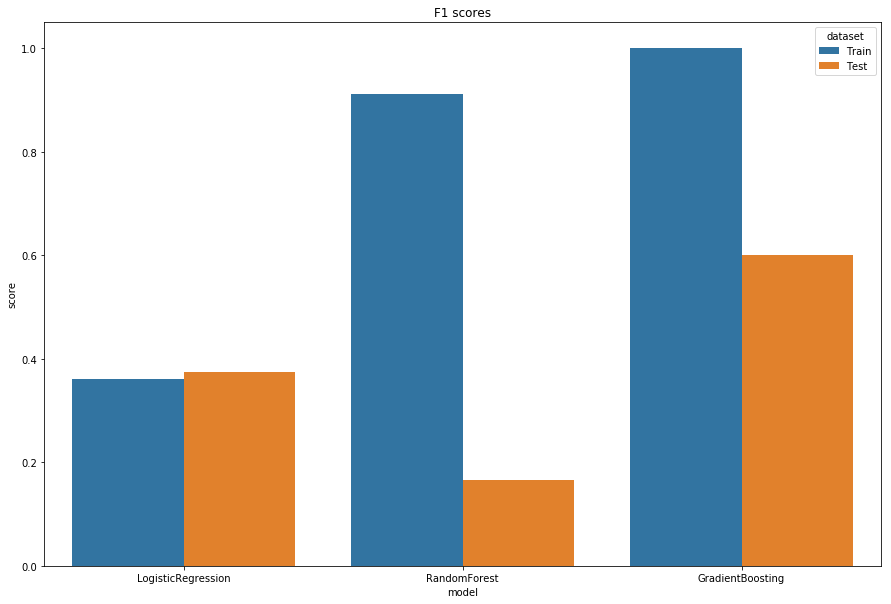

In [27]:
plt.figure(figsize=(15,10))
sns.barplot(x='model', y='score', hue='dataset', data=results_df)
plt.title('F1 scores')
plt.show()

In [39]:
print('F1 score in Logistic Regression model in trainset: ',  calculate_f1(results_lr_train))
print('F1 score in Logistic Regression model in testset: ', calculate_f1(results_lr_test))
print('F1 score in Random Forest model in trainset: ', calculate_f1(results_rf_train))
print('F1 score in Random Forest model in testset: ', calculate_f1(results_rf_test))
print('F1 score in Gradient Boosting model in trainset: ', calculate_f1(results_gbt_train))
print('F1 score in Gradient Boosting model in testset: ', calculate_f1(results_gbt_test))

F1 score in Logistic Regression model in trainset:  0.36065573770491804
F1 score in Logistic Regression model in testset:  0.375
F1 score in Random Forest model in trainset:  0.9113924050632911
F1 score in Random Forest model in testset:  0.16666666666666666
F1 score in Gradient Boosting model in trainset:  1.0
F1 score in Gradient Boosting model in testset:  0.6


In [42]:
gbt = GBTClassifier()

paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxIter, np.arange(10, 30, 10)) \
    .addGrid(gbt.maxDepth, np.arange(3, 7, 1)) \
    .addGrid(gbt.minInstancesPerNode, [1, 10, 20]) \
    .build()

crossval = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=5)
gbt_model_refined = crossval.fit(train)
results_gbt = gbt_model_refined.transform(test)
results_gbt_tr = gbt_model_refined.transform(train)

In [43]:
print('F1 score in Gradient Boosting model in trainset: ', calculate_f1(results_gbt_tr))
print('F1 score in Gradient Boosting model in testset: ', calculate_f1(results_gbt))

F1 score in Gradient Boosting model in trainset:  0.8
F1 score in Gradient Boosting model in testset:  0.4800000000000001


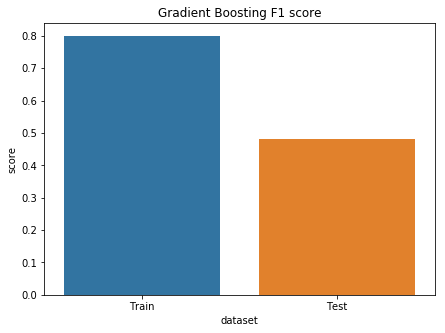

In [44]:
results_df = pd.DataFrame({'score': [calculate_f1(results_gbt_tr), calculate_f1(results_gbt)],
                           'dataset': ['Train', 'Test']})
plt.figure(figsize=(7,5))
sns.barplot(x='dataset', y='score', data=results_df)
plt.title('Gradient Boosting F1 score')
plt.show()

In [45]:
gbt_model.avgMetrics

[0.6532052669552669,
 0.6501196064284298,
 0.6713964398890869,
 0.6713964398890869,
 0.6611285827462298,
 0.6522474747474748,
 0.6358338921427156,
 0.6798785827462298,
 0.6713964398890869,
 0.6633607256033727,
 0.6479772302860538,
 0.6358338921427156,
 0.6837454658631129,
 0.68151332300597,
 0.6801740372916842,
 0.6472851908440144,
 0.6344442817531053,
 0.6730311801488271,
 0.6841918944345414,
 0.6828526087202558]

In [46]:
gbt_model.bestModel.featureImportances

SparseVector(23, {0: 0.0155, 1: 0.1256, 2: 0.0048, 3: 0.3899, 4: 0.0, 5: 0.0694, 6: 0.0008, 7: 0.028, 8: 0.0177, 9: 0.0028, 10: 0.0296, 11: 0.0, 12: 0.0, 13: 0.0076, 15: 0.0203, 16: 0.0211, 17: 0.0726, 19: 0.0, 20: 0.1193, 21: 0.0435, 22: 0.0314})

In [47]:
columns

['gender',
 'songsListened',
 'totalSessions',
 'totalDays',
 'level',
 'avgSessionTime',
 'About',
 'Add Friend',
 'Add to Playlist',
 'Downgrade',
 'Error',
 'Help',
 'Home',
 'Logout',
 'NextSong',
 'Roll Advert',
 'Save Settings',
 'Settings',
 'Submit Downgrade',
 'Submit Upgrade',
 'Thumbs Down',
 'Thumbs Up',
 'Upgrade']

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

In [75]:
print(pyspark.__version__, np.__version__, pd.__version__, sns.__version__)

2.4.3 1.12.1 0.23.3 0.8.1


In [76]:
import matplotlib
print(matplotlib.__version__)

2.1.0
